# Imports and Color Set

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import cpi
import tol_colors as tc
import numpy as np
from matplotlib.patches import Patch
import seaborn as sns
import os.path

In [2]:
plt.figure(figsize=(13,13))
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 20
cset = tc.tol_cset('bright')

<Figure size 936x936 with 0 Axes>

# Descriptive - Generation, Revenue, Customers

## Importing and merging EIA form 861 data

In [3]:
path = "../datafiles/Merged EIA data.csv"

if os.path.isfile(path):
    all_eia = pd.read_csv(path)
else:
    #Iterate over EIA 861 tables from 2014-2022
    yrs = list(range(2014,2023))
    yr_dfs=[]
    for yr in yrs:
        #Load in a file
        file = 'Sales_Ult_Cust_'+str(yr)+'.xlsx'
        df=pd.read_excel('../datafiles/EIA Data/'+file,sheet_name="States",header=2)

        #Keep only California IOUs, MOUs, CCAs
        df=df[((df['Ownership']=='Community Choice Aggregator') | (df['Ownership']=='Municipal') | (df['Ownership']=='Political Subdivision') |(df['Ownership']=='Investor Owned') |  (df['Utility Name']=='Southern California Edison Co')) & (df['State']=='CA')]

        #Rename ownership to abbreviation
        df['Ownership'] = df['Ownership'].map({'Investor Owned': 'IOU',
                                               'Community Choice Aggregator': 'CCA',
                                               'Municipal':'POU',
                                               'Political Subdivision':'POU'
                                              })


        #Only keep useful columns, and make them integers
        df=df[['Data Year', 'Utility Name','Service Type','Ownership','Thousand Dollars.1','Megawatthours.1','Count.1','Thousand Dollars.2','Megawatthours.2','Count.2','Thousand Dollars','Megawatthours','Count']]
        cols = ['Thousand Dollars.1','Megawatthours.1','Count.1','Thousand Dollars.2','Megawatthours.2','Count.2','Thousand Dollars','Megawatthours','Count']
        df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1).fillna(0)

        #Rename columns to make sense
        df=df.rename(columns={"Data Year": "Year", 
                              "Thousand Dollars": "Revenue (thousand$)_res",'Megawatthours':'Sales (MWh)_res','Count':'Customers_res',
                             "Thousand Dollars.1": "Revenue (thousand$)_com",'Megawatthours.1':'Sales (MWh)_com','Count.1':'Customers_com',
                             "Thousand Dollars.2": "Revenue (thousand$)_ind",'Megawatthours.2':'Sales (MWh)_ind','Count.2':'Customers_ind'})

        #Ensure everything is in integer form
        df.astype({"Revenue (thousand$)_res":'int32','Sales (MWh)_res':'int32','Customers_res':'int32',
                              "Revenue (thousand$)_com":'int32','Sales (MWh)_com':'int32','Customers_com':'int32',
                              "Revenue (thousand$)_com":'int32','Sales (MWh)_com':'int32','Customers_ind':'int32'})



        #Keep only 3 chosen utilities
        df['Utility Name'] = df['Utility Name'].str.replace('.', '',regex=False)
        df=df[(df['Utility Name']=='Southern California Edison Co')|(df['Utility Name']=='Pacific Gas & Electric Co')|(df['Utility Name']=='San Diego Gas & Electric Co')
             | (df['Utility Name']=='Los Angeles Department of Water & Power')|(df['Utility Name']=='Sacramento Municipal Util Dist')|(df['Utility Name']=='Imperial Irrigation District')
             |(df['Utility Name']=='Marin Clean Energy')|(df['Utility Name']=='East Bay Community Energy')|(df['Utility Name']=='Clean Power Alliance of Southern Califor')]    

        df.reset_index(drop=True,inplace=True)
        yr_dfs.append(df)

    #Merge all EIA into a single form and output to CSV
    all_eia = pd.concat(yr_dfs)
    all_eia.to_csv(path)

## Consolidating cust, revenue, sales data for top 3 IOUs, POUs, CCAs

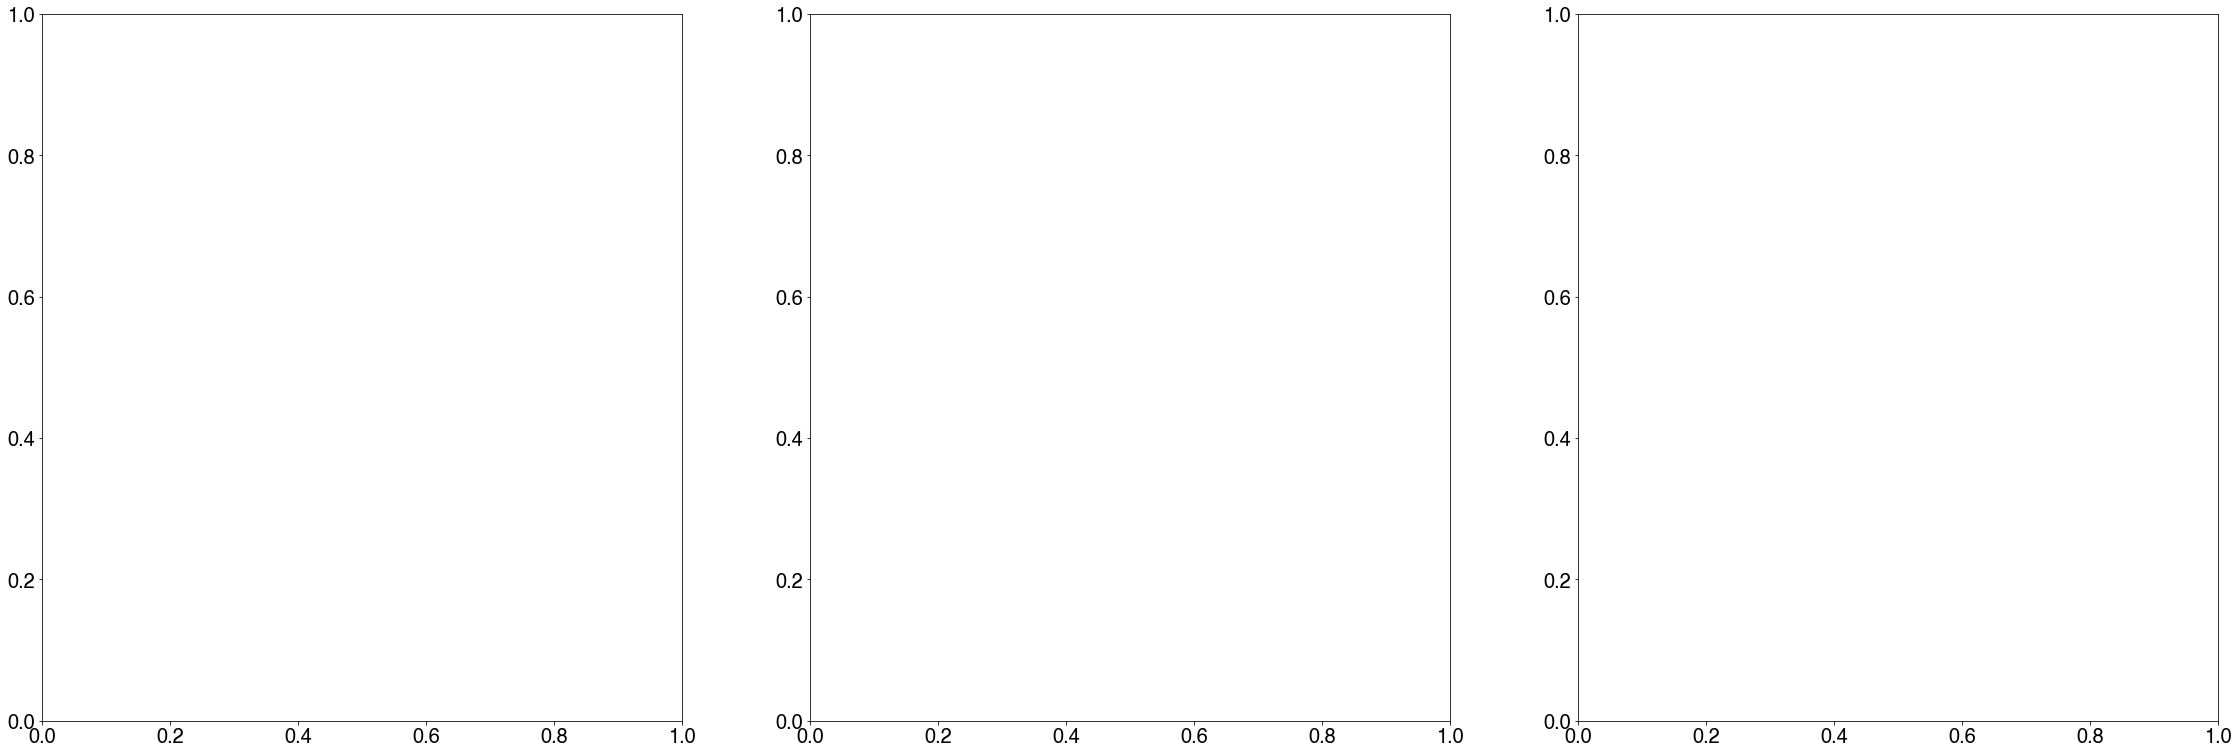

In [4]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(39,13))

In [5]:
#Slice to just data from 2022
latest_year = all_eia[all_eia['Year']==2022].copy()

#Sort
latest_year.sort_values(by=['Customers_res'],inplace=True)
latest_year.sort_values(by=['Ownership'],inplace=True)

#GRAPHING HELPERS

#Make an array of x values for the bar chart x-axis
def string_to_integer_mapping(strings):
    seen = {}
    result = []
    for string in strings:
        if string not in seen:
            seen[string] = len(seen)
        result.append(seen[string])
    return result
x_vals = np.array(string_to_integer_mapping(latest_year['Utility Name']))


#New columns - base height and column color for each type
latest_year['BaseHeight_res']=0
latest_year['BaseHeight_com']=0
latest_year['BaseHeight_ind']=0

latest_year['Color_res']='#4477AA'
latest_year['Color_com']='#EE6677'
latest_year['Color_ind']='#BBBBBB'

#Iterate over each row in the table, and where we have a delivery-only row, give it a "bottom" height, so that it gets stacked on top of the "bundled" bar
for index, row in latest_year.iterrows():   
    if row['Service Type']=='Delivery':
        latest_year.at[index,'Color_res']='#66CCEE'
        latest_year.at[index,'BaseHeight_res'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Customers_res'].item()
        
        latest_year.at[index,'Color_com']='#AA3377'
        latest_year.at[index,'BaseHeight_com'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Customers_com'].item()
        
        latest_year.at[index,'Color_ind']='#000000'
        latest_year.at[index,'BaseHeight_ind'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Customers_ind'].item()
        
#Cleanup names to just include uppercase characters
for index, row in latest_year.iterrows():
    base_string = row['Utility Name'].replace('Authority','').replace('.','')
    no_co = base_string[:-2] if base_string.endswith("Co") else base_string
    latest_year.at[index,'Utility Name'] = ''.join([c for c in no_co if ((c.isupper())|(c=='&'))])

#Begin plotting
#plt.figure(figsize=(13,13))
#width=0.25
axs[0].bar(x_vals,height=latest_year['Customers_res']/1e6,bottom=latest_year['BaseHeight_res']/1e6,color=latest_year['Color_res'])#,width=width)
#plt.bar(x_vals,height=latest_year['Customers_com'],bottom=latest_year['BaseHeight_com'],color=latest_year['Color_com'],width=width)
#plt.bar(x_vals+width,height=latest_year['Customers_ind'],bottom=latest_year['BaseHeight_ind'],color=latest_year['Color_ind'],width=width)

#plt.yscale("log")
axs[0].set_xticks(ticks=np.arange(len(latest_year['Utility Name'].unique())),
           labels=latest_year['Utility Name'].unique(),
           rotation=90)
axs[0].set_title('Number of Customers (millions)')
#Add vertical lines to separate different types of utilities

#Helper function that finds transitions between ownership types
temp_newdf_forlines = latest_year.drop_duplicates(subset='Utility Name', keep="last")
def find_transition_indices(lst):
    transition_indices = []
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            transition_indices.append(i - 1)
    return np.array(transition_indices)
lst = temp_newdf_forlines['Ownership'].to_list()
result = find_transition_indices(lst)
axs[0].vlines(x=result+0.5,ymin=0,ymax=1e7,linestyles='dotted',linewidth=5,color='k')
axs[0].set_ylim([0,5])
axs[0].set_xlabel('Utility Name')
axs[0].set_ylabel('Number of Customers (millions)')

#Construct legend

legend_elements = [Patch(facecolor='#4477AA', edgecolor='#4477AA',label='Residential'),
                   Patch(facecolor='#66CCEE', edgecolor='#66CCEE',label='Residential\nDeliveryOnly'),
                   #Patch(facecolor='#EE6677', edgecolor='#EE6677',label='Commercial'),
                   ##Patch(facecolor='#AA3377', edgecolor='#AA3377',label='Commercial\nDeliveryOnly'),
                   #Patch(facecolor='#BBBBBB', edgecolor='#BBBBBB',label='Industrial'),
                   #Patch(facecolor='#000000', edgecolor='#000000',label='Industrial\nDeliveryOnly')
                  ]

#axs[0].legend(handles=legend_elements,loc='upper right',bbox_to_anchor=(1.3,1))

In [6]:
#Slice to just data from 2022
latest_year = all_eia[all_eia['Year']==2022].copy()

#Sort
latest_year.sort_values(by=['Sales (MWh)_res'],inplace=True)
latest_year.sort_values(by=['Ownership'],inplace=True)

#GRAPHING HELPERS

#Make an array of x values for the bar chart x-axis
def string_to_integer_mapping(strings):
    seen = {}
    result = []
    for string in strings:
        if string not in seen:
            seen[string] = len(seen)
        result.append(seen[string])
    return result
x_vals = np.array(string_to_integer_mapping(latest_year['Utility Name']))


#New columns - base height and column color for each type
latest_year['BaseHeight_res']=0
latest_year['BaseHeight_com']=0
latest_year['BaseHeight_ind']=0

latest_year['Color_res']='#4477AA'
latest_year['Color_com']='#EE6677'
latest_year['Color_ind']='#BBBBBB'

#Iterate over each row in the table, and where we have a delivery-only row, give it a "bottom" height, so that it gets stacked on top of the "bundled" bar
for index, row in latest_year.iterrows():   
    if row['Service Type']=='Delivery':
        latest_year.at[index,'Color_res']='#66CCEE'
        latest_year.at[index,'BaseHeight_res'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Sales (MWh)_res'].item()
        
        latest_year.at[index,'Color_com']='#AA3377'
        latest_year.at[index,'BaseHeight_com'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Sales (MWh)_com'].item()
        
        latest_year.at[index,'Color_ind']='#000000'
        latest_year.at[index,'BaseHeight_ind'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Sales (MWh)_ind'].item()
        
#Cleanup names to just include uppercase characters
for index, row in latest_year.iterrows():
    base_string = row['Utility Name'].replace('Authority','').replace('.','')
    no_co = base_string[:-2] if base_string.endswith("Co") else base_string
    latest_year.at[index,'Utility Name'] = ''.join([c for c in no_co if ((c.isupper())|(c=='&'))])

#Begin plotting
#plt.figure(figsize=(13,13))
#width=0.25
axs[1].bar(x_vals,height=latest_year['Sales (MWh)_res']/1e6,bottom=latest_year['BaseHeight_res']/1e6,color=latest_year['Color_res'])#,width=width)
#plt.bar(x_vals,height=latest_year['Sales (MWh)_com'],bottom=latest_year['BaseHeight_com'],color=latest_year['Color_com'],width=width)
#plt.bar(x_vals+width,height=latest_year['Sales (MWh)_ind'],bottom=latest_year['BaseHeight_ind'],color=latest_year['Color_ind'],width=width)

#plt.yscale("log")
axs[1].set_xticks(ticks=np.arange(len(latest_year['Utility Name'].unique())),
           labels=latest_year['Utility Name'].unique(),
           rotation=90)
axs[1].set_title('Sales (TWh)')

#Add vertical lines to separate different types of utilities

#Helper function that finds transitions between ownership types
temp_newdf_forlines = latest_year.drop_duplicates(subset='Utility Name', keep="last")
def find_transition_indices(lst):
    transition_indices = []
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            transition_indices.append(i - 1)
    return np.array(transition_indices)
lst = temp_newdf_forlines['Ownership'].to_list()
result = find_transition_indices(lst)

ymax=30
axs[1].vlines(x=result+0.5,ymin=0,ymax=ymax,linestyles='dotted',linewidth=5,color='k')
axs[1].set_ylim([0,ymax])
axs[1].set_xlabel('Utility Name')
axs[1].set_ylabel('Sales (TWh)')

#Construct legend

legend_elements = [Patch(facecolor='#4477AA', edgecolor='#4477AA',label='Residential'),
                   Patch(facecolor='#66CCEE', edgecolor='#66CCEE',label='Residential\nDeliveryOnly'),
                   #Patch(facecolor='#EE6677', edgecolor='#EE6677',label='Commercial'),
                   #Patch(facecolor='#AA3377', edgecolor='#AA3377',label='Commercial\nDeliveryOnly'),
                   #Patch(facecolor='#BBBBBB', edgecolor='#BBBBBB',label='Industrial'),
                   #Patch(facecolor='#000000', edgecolor='#000000',label='Industrial\nDeliveryOnly')
                  ]

#axs[1].legend(handles=legend_elements,loc='upper right',bbox_to_anchor=(1.3,1))

In [7]:
#Slice to just data from 2022
latest_year = all_eia[all_eia['Year']==2022].copy()

#Sort
latest_year.sort_values(by=['Revenue (thousand$)_res'],inplace=True)
latest_year.sort_values(by=['Ownership'],inplace=True)

#GRAPHING HELPERS

#Make an array of x values for the bar chart x-axis
def string_to_integer_mapping(strings):
    seen = {}
    result = []
    for string in strings:
        if string not in seen:
            seen[string] = len(seen)
        result.append(seen[string])
    return result
x_vals = np.array(string_to_integer_mapping(latest_year['Utility Name']))


#New columns - base height and column color for each type
latest_year['BaseHeight_res']=0
latest_year['BaseHeight_com']=0
latest_year['BaseHeight_ind']=0

latest_year['Color_res']='#4477AA'
latest_year['Color_com']='#EE6677'
latest_year['Color_ind']='#BBBBBB'

#Iterate over each row in the table, and where we have a delivery-only row, give it a "bottom" height, so that it gets stacked on top of the "bundled" bar
for index, row in latest_year.iterrows():   
    if row['Service Type']=='Delivery':
        latest_year.at[index,'Color_res']='#66CCEE'
        latest_year.at[index,'BaseHeight_res'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Revenue (thousand$)_res'].item()
        
        latest_year.at[index,'Color_com']='#AA3377'
        latest_year.at[index,'BaseHeight_com'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Revenue (thousand$)_com'].item()
        
        latest_year.at[index,'Color_ind']='#000000'
        latest_year.at[index,'BaseHeight_ind'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Revenue (thousand$)_ind'].item()
        
#Cleanup names to just include uppercase characters
for index, row in latest_year.iterrows():
    base_string = row['Utility Name'].replace('Authority','').replace('.','')
    no_co = base_string[:-2] if base_string.endswith("Co") else base_string
    latest_year.at[index,'Utility Name'] = ''.join([c for c in no_co if ((c.isupper())|(c=='&'))])

#Begin plotting
#plt.figure(figsize=(13,13))
#width=0.25
axs[2].bar(x_vals+0.5,height=latest_year['Revenue (thousand$)_res']/1e6,bottom=latest_year['BaseHeight_res']/1e6,color=latest_year['Color_res'])#,width=width)
#plt.bar(x_vals,height=latest_year['Revenue (thousand$)_com'],bottom=latest_year['BaseHeight_com'],color=latest_year['Color_com'],width=width)
#plt.bar(x_vals+width,height=latest_year['Revenue (thousand$)_ind'],bottom=latest_year['BaseHeight_ind'],color=latest_year['Color_ind'],width=width)

#plt.yscale("log")
axs[2].set_xticks(ticks=np.arange(len(latest_year['Utility Name'].unique())),
           labels=latest_year['Utility Name'].unique(),
           rotation=90)
axs[2].set_title('Revenue (billion 2022$)')

#Add vertical lines to separate different types of utilities

#Helper function that finds transitions between ownership types
temp_newdf_forlines = latest_year.drop_duplicates(subset='Utility Name', keep="last")
def find_transition_indices(lst):
    transition_indices = []
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            transition_indices.append(i - 1)
    return np.array(transition_indices)
lst = temp_newdf_forlines['Ownership'].to_list()
result = find_transition_indices(lst)

ymax=7
axs[2].vlines(x=result+0.5,ymin=0,ymax=ymax,linestyles='dotted',linewidth=5,color='k')
axs[2].set_ylim([0,ymax])
axs[2].set_xlabel('Utility Name')
axs[2].set_ylabel('Revenue (billion 2022$)')

#Construct legend

legend_elements = [Patch(facecolor='#4477AA', edgecolor='#4477AA',label='Residential'),
                   Patch(facecolor='#66CCEE', edgecolor='#66CCEE',label='Residential\nDeliveryOnly'),
                   #Patch(facecolor='#EE6677', edgecolor='#EE6677',label='Commercial'),
                   ##Patch(facecolor='#AA3377', edgecolor='#AA3377',label='Commercial\nDeliveryOnly'),
                   #Patch(facecolor='#BBBBBB', edgecolor='#BBBBBB',label='Industrial'),
                   #Patch(facecolor='#000000', edgecolor='#000000',label='Industrial\nDeliveryOnly')
                  ]

axs[2].legend(handles=legend_elements,loc='upper right',bbox_to_anchor=(1.3,1))
fig
fig.savefig('Fig1_2022 snapshot of top 3 utilities.png',dpi=600,bbox_inches='tight')

/var/folders/h0/rfb20rk90qz0tdgv08kqcyrw0000gn/T/ipykernel_16811/4097335997.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1494073.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  latest_year.at[index,'BaseHeight_res'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Revenue (thousand$)_res'].item()
/var/folders/h0/rfb20rk90qz0tdgv08kqcyrw0000gn/T/ipykernel_16811/4097335997.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '784580.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  latest_year.at[index,'BaseHeight_com'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Revenue (thousand$)_com'].item()
/var/folders/h0/r